In [ ]:
# ---- Import Libraries ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

print("All libraries installed and imported successfully!")

All libraries installed and imported successfully!


Collect the Stock Data from AAPL

In [ ]:
stock_data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454506,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465664,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362819,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351057,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393280,447610800


In [ ]:
# ---- Data Preprocessing ----
# Scale the 'Close' prices for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

# Function to create dataset with time steps
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


In [ ]:

# Define time step and split data
time_step = 60
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# ---- Build and Train LSTM Model ----
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.0061
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.6400e-04
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 2.2860e-04
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 2.3419e-04
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 1.9874e-04
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 1.7938e-04
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 1.7266e-04
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 1.6270e-04
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 1.1873e-04
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 1.8838e-04


In [ ]:
# ---- Make Predictions ----
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [ ]:
from sklearn.metrics import r2_score

# Inverse transform the test data to get actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate R² score
r2 = r2_score(y_test_actual, predictions)
print(f'R² score: {r2}')


R² score: 0.8547399383423148


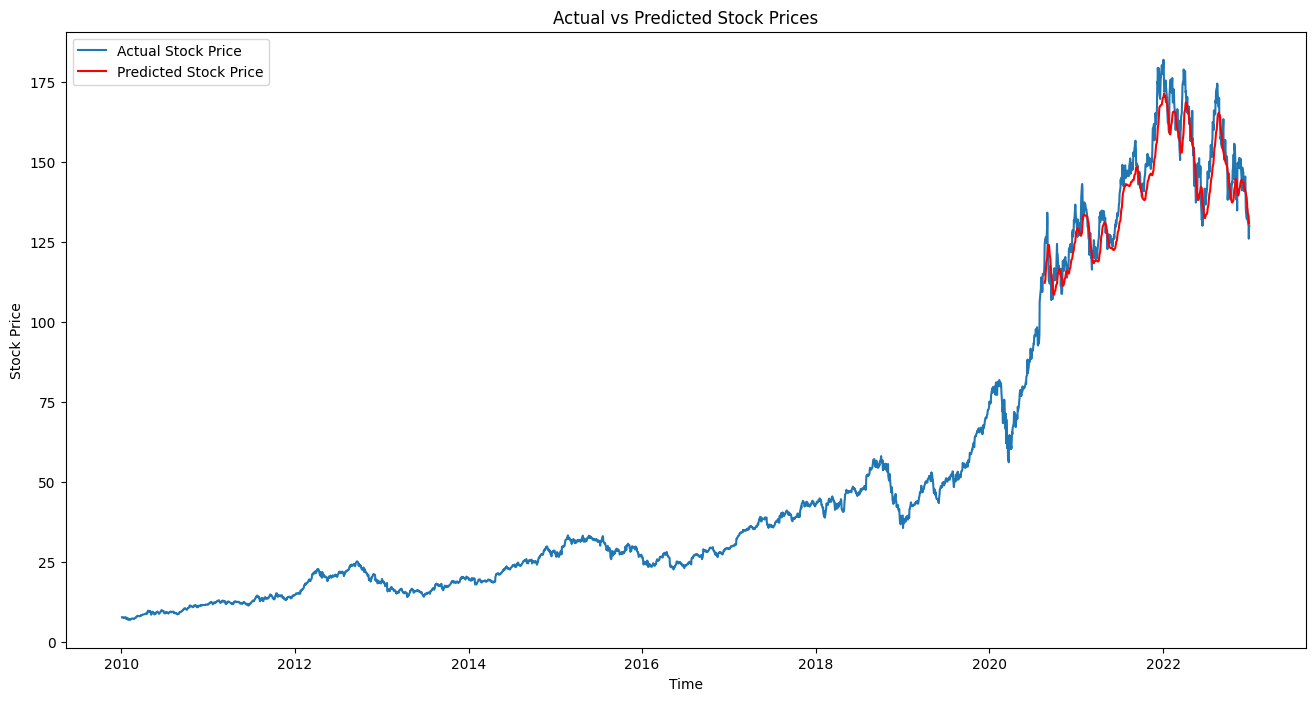

In [ ]:
# Plot the actual stock prices
plt.figure(figsize=(16, 8))

# Plot actual stock prices (only the part related to the test set)
plt.plot(stock_data.index, stock_data['Close'], label='Actual Stock Price')

# Plot predicted stock prices, aligning them with the correct indices in the test set
prediction_start_index = train_size + time_step
plt.plot(stock_data.index[prediction_start_index:prediction_start_index + len(predictions)],
         predictions, label='Predicted Stock Price', color='red')

# Add titles, labels, and legend
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Show the plot
plt.show()
